In [1]:
# nbi:hide_in
# nbi:hide_out
# - Deployment
import nbinteract as nbi

# - Transformações
import pandas as pd
import numpy as np

# - Widgets
import ipywidgets as widgets
from IPython.display import display, HTML
from IPython.display import clear_output
from ipywidgets import interact, interact_manual


# - Visualização
import seaborn as sns
import squarify
from seaborn import countplot

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import matplotlib.dates as dates

In [2]:
# nbi:hide_in
# nbi:hide_out
# - Modifica formato de todos os gráficos
sns.set(rc={'figure.figsize': (11.7, 8.27)})

In [3]:
# nbi:hide_in
# ----- Funções Plot -----


def pie_chart(df_aux, coluna):
    # Pie chart
    labels = df_aux[coluna].unique()
    sizes = [len(df_aux.loc[df_aux[coluna] == i])
             for i in df_aux[coluna].unique()]

    # Define Cores
    # colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
    color = [plt.cm.Spectral(i/float(len(labels)))
             for i in range(len(labels))]

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, colors=color,
            labels=labels, autopct='%1.1f%%', startangle=180)

    # - Desenha Donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # - 'Equal' o 'aspect ratio' para garantir que a torta tenha um formato de círculo
    ax1.axis('equal')
    leg = ax1.legend()
    plt.tight_layout()
    plt.show()
    return


def treemap_plot(df_aux, coluna):
    # Prepare Data
    df_plot = df_aux.groupby(coluna).size().reset_index(name='counts')
    labels = df_plot.apply(lambda x: str(
        x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = df_plot['counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels)))
              for i in range(len(labels))]

    # Draw Plot
    plt.figure(figsize=(12, 8), dpi=80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    # Decorate
    plt.title('Treemap')
    plt.axis('off')
    plt.show()
    return

In [4]:
# nbi:hide_in
# ----- Funções RFM Churn -----


def recency(df_aux):
    '''
    Função cria Dataframe com associado_id + data_última_compra
    '''

    # - Define data mais recente
    data_mais_recente = df_aux.data_local.max()

    # - Remove colunas desnecessárias para o cálculo de Recency
    clean_recency = df_aux.drop(['compra_id',
                                 'programa_id',
                                 'parceiro_id',
                                 'loja_id',
                                 'data_servidor',
                                 'origem',
                                 'qtd_cupons',
                                 'forma_identificacao',
                                 'cartao_gestor',
                                 'cod_atendente',
                                 'nota_fiscal_id',
                                 'situacao_associado',
                                 'situacao',
                                 'valor_inicial',
                                 'valor_final',
                                 'valor_resgatado',
                                 'valor_desconto',
                                 'valor_troco',
                                 'acumulo_total',
                                 'teve_resgate'],
                                axis=1)

    # - Localiza data mais recente para cada associado
    df_rec = clean_recency.loc[clean_recency.groupby(
        'associado_id').data_local.idxmax()]

    # - Subtraí data mais recente da última data para cada associado
    df_rec.data_local = (
        data_mais_recente -
        df_rec.data_local).astype('timedelta64[D]')

    # - Altera nome das colunas
    df_rec = df_rec.rename(index=str, columns={"data_local": "rec"})

    # - Transforma a quantidade de dias da última compra em inteiro
    df_rec.rec = df_rec.rec.astype(int)

    return df_rec


def frequency(df_aux):
    '''
    Função cria Dataframe com associado_id + quantidade de compras
    '''

    # - Remove colunas desnecessárias para o cálculo de Frequency
    clean_frequency = df_aux.drop(['valor_final',
                                   'data_local',
                                   'compra_id',
                                   'programa_id',
                                   'parceiro_id',
                                   'loja_id',
                                   'data_servidor',
                                   'origem',
                                   'qtd_cupons',
                                   'forma_identificacao',
                                   'cartao_gestor',
                                   'cod_atendente',
                                   'nota_fiscal_id',
                                   'situacao_associado',
                                   'situacao',
                                   'valor_inicial',
                                   'valor_resgatado',
                                   'valor_desconto',
                                   'valor_troco',
                                   'acumulo_total',
                                   'teve_resgate'],
                                  axis=1)

    # - Conta a quantidade de compras por associado
    counts = clean_frequency['associado_id'].value_counts().to_dict()

    # - Cria dataframe Frequency
    df_fre = pd.DataFrame(counts.items(), columns=['associado_id', 'freq'])

    return df_fre


def monetary(df_aux):
    '''
    Função cria Dataframe com associado_id + soma de gastos
    '''

    # - Remove colunas desnecessárias para o cálculo de Monetary
    clean_monetary = df_aux.drop(['data_local',
                                  'compra_id',
                                  'programa_id',
                                  'parceiro_id',
                                  'loja_id',
                                  'data_servidor',
                                  'origem',
                                  'qtd_cupons',
                                  'forma_identificacao',
                                  'cartao_gestor',
                                  'cod_atendente',
                                  'nota_fiscal_id',
                                  'situacao_associado',
                                  'situacao',
                                  'valor_inicial',
                                  'valor_resgatado',
                                  'valor_desconto',
                                  'valor_troco',
                                  'acumulo_total',
                                  'teve_resgate'],
                                 axis=1)

    # - Soma todos os gastos por usuário
    df_mon = (clean_monetary.groupby(['associado_id']).sum()).reset_index()

    return df_mon


def longetivity(df_aux):
    '''
    Função cria Dataframe com associado_id + longevidade
    '''
    # - Define data mais recente
    data_mais_recente = df_aux.data_local.max()

    # - Remove colunas desnecessárias para o cálculo de Monetary
    clean_longe = df_aux[['associado_id', 'data_local']]

    # - Localiza data da primeira compra para cada associado
    longetivity = clean_longe.loc[clean_longe.groupby(
        'associado_id').data_local.idxmin()]

    # - Subtraí data mais recente da data da primeira compra para cada associado
    longetivity['long'] = (data_mais_recente -
                           longetivity.data_local).astype('timedelta64[D]')

    # - Transforma a quantidade de dias da primeira compra por inteiro
    longetivity.long = longetivity.long.astype(int)

    # - Remove coluna data_local
    longetivity.drop(['data_local'], axis=1, inplace=True)

    return longetivity


def RScore(x, p, d):
    '''
    Função para retornar as notas de Recency
    - Com Recency os valores de rank 1 são os centrais
    '''
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4


def FMScore(x, p, d):
    '''
    Função para retornar as notas de Frequency e Monetary
    - Com Monetary e Frequency os valores de rank 1 se concentram nas pontas
    '''
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1


def rfmRank(df_entrada):
    '''
    Função para a criação do csv final contendo o rank RFM
    '''
    # - Cria uma cópia do Dataframe para não alterar o original
    segmented_rfm = df_entrada.copy()

    # - Define quantiles de agrupamento
    quantiles = segmented_rfm.quantile(q=[0.25, 0.5, 0.75])
    quantiles = quantiles.to_dict()

    segmented_rfm['r_quartile'] = segmented_rfm['Recency'].apply(
        RScore, args=('Recency', quantiles,))
    segmented_rfm['f_quartile'] = segmented_rfm['Frequency'].apply(
        FMScore, args=('Frequency', quantiles,))
    segmented_rfm['m_quartile'] = segmented_rfm['Monetary'].apply(
        FMScore, args=('Monetary', quantiles,))

    # - Combina os valores para criar o RFMScore
    segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(
        str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)

    return segmented_rfm


def define_cat_rfm(df_entrada):
    # - Cria uma cópia do Dataframe para não alterar o original
    df = df_entrada.copy()

    df['categoria'] = ''

    # - Categorias básica
    df.loc[df.r_quartile.isin([1, 2]) & df.f_quartile.isin(
        [1, 2]) & df.m_quartile.isin([1, 2]), 'categoria'] = 'Destaque'
    df.loc[df.r_quartile.isin([1, 2]) & df.f_quartile.isin(
        [1, 2]) & df.m_quartile.isin([3, 4]), 'categoria'] = 'Proximo Fiel Limitado'
    df.loc[df.r_quartile.isin([1, 2]) & df.f_quartile.isin(
        [3, 4]) & df.m_quartile.isin([1, 2]), 'categoria'] = 'Novo Valioso'
    df.loc[df.r_quartile.isin([3, 4]) & df.f_quartile.isin(
        [1, 2]) & df.m_quartile.isin([1, 2]), 'categoria'] = 'Distante Fiel Valioso'
    df.loc[df.r_quartile.isin([3, 4]) & df.f_quartile.isin(
        [3, 4]) & df.m_quartile.isin([3, 4]), 'categoria'] = 'Distante Limitado'
    df.loc[df.r_quartile.isin([3, 4]) & df.f_quartile.isin(
        [3, 4]) & df.m_quartile.isin([1, 2]), 'categoria'] = 'Distante Valioso'
    df.loc[df.r_quartile.isin([1, 2]) & df.f_quartile.isin(
        [3, 4]) & df.m_quartile.isin([3, 4]), 'categoria'] = 'Novo Limitado'
    df.loc[df.r_quartile.isin([3, 4]) & df.f_quartile.isin(
        [1, 2]) & df.m_quartile.isin([3, 4]), 'categoria'] = 'Distante Fiel Limitado'

    # - Categorias especiais
    df.loc[df.r_quartile.isin([1]) & df.f_quartile.isin(
        [1]) & df.m_quartile.isin([1]), 'categoria'] = 'Vip'
    df.loc[df.r_quartile.isin([4]) & df.f_quartile.isin(
        [4]) & df.m_quartile.isin([4]), 'categoria'] = 'Problematico'

    return df


def define_cat_churn(row):
    if row.churn < 1:
        return '0'
    if row.churn == 1:
        return '1'
    if ((row["churn"] > 1) & (row["churn"] <= 10)):
        return '2'
    if ((row["churn"] > 10) & (row["churn"] <= 100)):
        return '3'
    if row.churn > 100:
        return '4'


def cria_churn(df_1, df_2, df_3):
    '''
    Cria Arquivo Churn
    '''

    # - Unifica dataframes longevidade, frequência e recência por associado_id
    df_ch = pd.merge(
        pd.merge(
            df_1,
            df_2,
            on='associado_id'),
        df_3,
        on='associado_id')

    # - Calcula frequência de atividades
    df_ch['act_freq'] = (df_ch.long - df_ch.rec) / (df_ch.freq - 1)

    # - Calcula churn
    df_ch['churn'] = (df_ch.rec) / (df_ch.act_freq)

    # - Trata usuários novos, aqueles que possuem longevidade igual a zero, determinando act_freq e churn igual a zero
    df_ch.loc[df_ch['long'] == 0, 'act_freq'] = 0
    df_ch.loc[df_ch['long'] == 0, 'churn'] = 0

    # - Altera valores de churn Infinito pra 400, para que não sejam removidos na hora da visualização
    df_ch = df_ch.replace([np.inf], 400)

    # - Cria categorias Churn
    df_ch['categoria_churn'] = df_ch.apply(
        lambda row: define_cat_churn(row), axis=1)

    # - Atualiza tipo do dado associado_id
    df_ch.associado_id = df_ch.associado_id.astype(str)

    # - Define index como associado_id
    df_ch.set_index('associado_id', inplace=True)

    return df_ch


def cria_rfm(df_1, df_2, df_3):
    '''
    Cria Arquivo RFM
    '''
    # - Unifica dataframes por associado_id
    df_3 = pd.merge(
        pd.merge(
            df_1,
            df_2,
            on='associado_id'),
        df_3,
        on='associado_id')

    # - Define index como associado_id
    df_3 = df_3.set_index('associado_id')

    # - Atualiza nome das colunas
    df_3 = df_3.rename(
        index=str,
        columns={
            "freq": "Frequency",
            "valor_final": "Monetary",
            "rec": "Recency"})

    # - Cria rank
    df_rank_rfm = rfmRank(df_3)

    # - Cria categorias RFM
    df_cat_rfm = define_cat_rfm(df_rank_rfm)

    return df_cat_rfm


def RFMChurn(df_entrada):
    '''
    Cria Arquivo RFM e Churn
    Args:
        df_entrada: Dataframe inicial com dados
    Retorna:
        Os dataframe RFM e Churn
    '''

    # - Cria uma cópia do Dataframe para não alterar o original
    df_clean = df_entrada.copy()

    # - Calcula RFML
    df_r = recency(df_clean)
    df_f = frequency(df_clean)
    df_m = monetary(df_clean)
    df_l = longetivity(df_clean)

    # - Unifica dataframes por associado_id
    df_rfm = pd.merge(pd.merge(df_f, df_m, on='associado_id'),
                      df_r, on='associado_id')

    '''
    Cria Arquivo RFM
    '''
    df_rfm = cria_rfm(df_f, df_m, df_r)

    '''
    Cria Arquivo Churn
    '''
    df_churn = cria_churn(df_f, df_l, df_r)

    '''
    Cria Arquivo Final Contendo Churn + RFM
    '''
    df_rfmCh = pd.merge(df_rfm, df_churn, on='associado_id')

    # - Remove colunas repetidas, que foram utilizadas nos dois arquivos df_cat_rfm e df_churn
    df_rfmCh.drop(['freq', 'rec'], axis=1, inplace=True)

    # - Renomeia coluna longevidade
    df_rfmCh.rename(columns={'long': 'Longevity'}, inplace=True)

    return df_rfmCh


def main_rfm():
    # - Recebe arquivo
    df_fato_compra = df_fato.copy()
    df_fato_compra.drop(['Unnamed: 0'], axis=1, inplace=True)

    # - Converte data_local para datetime
    df_fato_compra.data_local = pd.to_datetime(df_fato_compra.data_local)

    # - Filtra informação
    df_clean = df_fato_compra[df_fato_compra.situacao == 'Confirmada']

    # - Cria arquivo RFM Churn
    df_RFMCH = RFMChurn(df_clean)

    return df_RFMCH

In [5]:
# nbi:hide_in
# nbi:hide_out
df_fato = pd.read_csv('raw/fato_compras.csv')
df = main_rfm()

C:\Users\rodrigo.sarmento\AppData\Local\Continuum\anaconda2\envs\Python\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Segmentação dos Associados
---

## Objetivo

- Segmentar os usuários para incrementar o número de consumidores fiéis.

## Vantagens de um Consumidor Fiel

- Geram mais referências.
- Continuarão comprando de você.
- Não estão procurando ativamente fornecedores alternativos.
- São menos suscetíveis ao marketing dos concorrentes.
- São mais receptivos aos seus outros produtos e serviços.
- Compreendem melhor os problemas e a solução de problemas.
- É mais provável que forneçam \textit{feedback} e comentários que você possa usar para melhorar sua retenção.

## Método RFM

O modelo de segmentação **RFM** do consumidor se baseia em três atributos:

- **R**ecency (Recência): A quanto tempo não consome na loja
- **F**requency (Frequência): Qual a frequência de compras em dado período
- **M**onetary (Valor): Qual a soma de gastos em dado período

A segmentação ocorre com a separação das variáveis **RFM** em quartis:

In [7]:
# nbi:hide_in
df[['Frequency', 'Monetary', 'Recency']].describe()

,Frequency,Monetary,Recency
count,65672.000000,65672.000000,65672.000000
mean,4.795270,314.993786,22.937523
std,8.237523,630.481664,25.353664
min,1.000000,0.010000,0.000000
25%,1.000000,41.960000,4.000000
50%,2.000000,124.080000,13.000000
75%,5.000000,353.031000,33.000000
max,262.000000,56927.005000,149.000000


- Devido a escolha de **quartis** para segmentação cada usuário terá uma nota entre 1 e 4 para as variáveis **RFM**. Dessa forma teremos em nosso modelo **64 categorias 4 x 4 x 4** 

### Categorias Criadas

- As 64 categorias foram reformuladas gerando 11 categorias finais
    - Vip
    - Destaque
    - Distante Fiel Valioso
    - Próximo Fiel Limitado
    - Distante Fiel Limitado
    - Distante Generoso
    - Novo Generoso
    - Novo Limitado

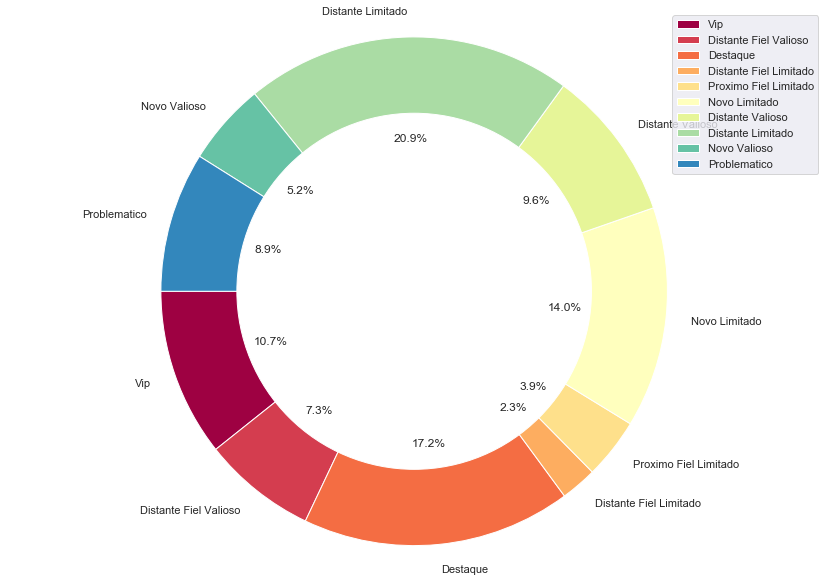

In [8]:
# nbi:hide_in
pie_chart(df,'categoria')

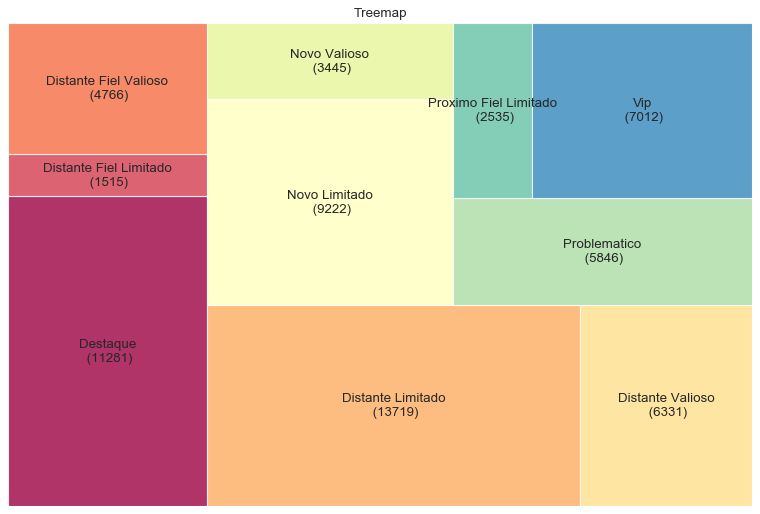

In [9]:
# nbi:hide_in
treemap_plot(df,'categoria')

## Método Fator Churn

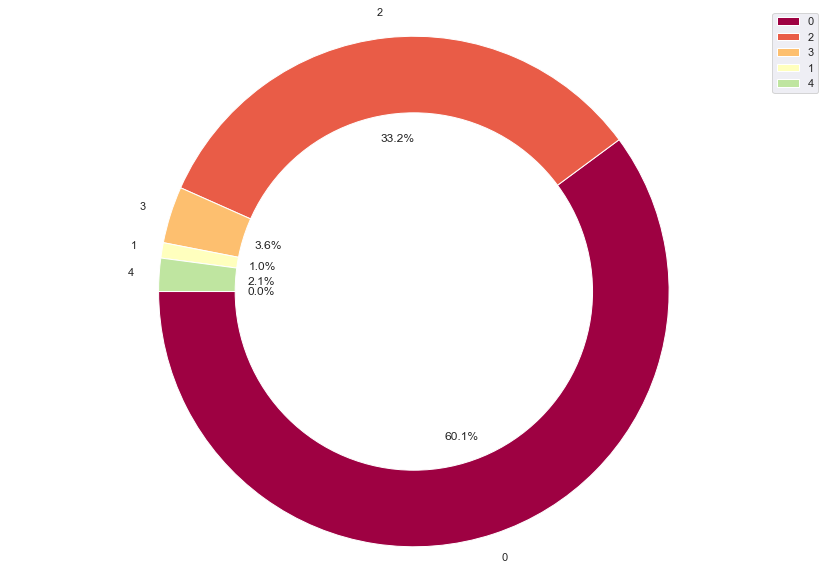

In [10]:
# nbi:hide_in
pie_chart(df,'categoria_churn')

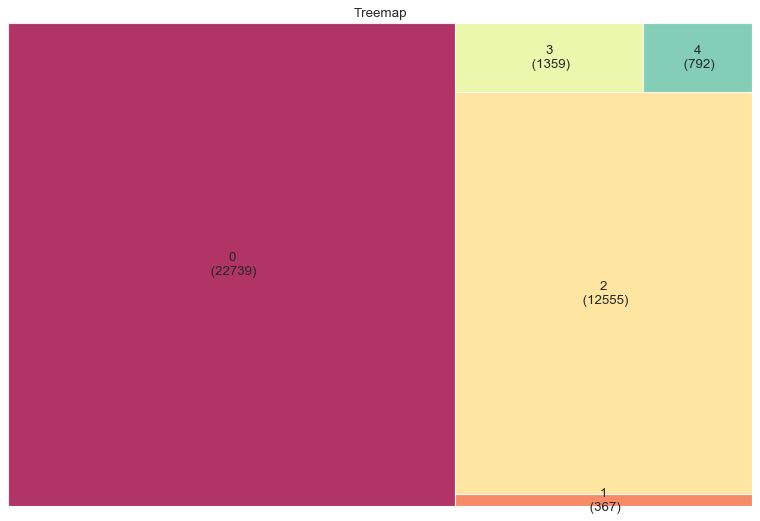

In [11]:
# nbi:hide_in
treemap_plot(df,'categoria_churn')

# Distribuição
---

## Histograma

In [6]:
# nbi:hide_in
def density_plot_var():
    # - Desenha Plot
    plt.figure(figsize=(16, 10), dpi=80)
    try:
        sns.kdeplot(df.loc[df['categoria'] == menu_distri.value,
                           menu_rfm.value], shade=True, color=plt.cm.Spectral(300), label="Distribuição", alpha=.7, shade_lowest=True)
    except:
        sns.kdeplot(df.replace([np.inf, -np.inf], np.nan).dropna().loc[df['categoria'] == menu_distri.value,
                                                                       menu_rfm.value], shade=True, color="dodgerblue", label="Distribuição", alpha=.7)

    # - Decoração
    plt.title('Distribuição '+menu_distri.value, fontsize=22)
    plt.legend()
    plt.show()
    return


def on_button_clicked(_):
    # - Click do botão
    # Função de linkagem
    with out_distri:
        # - Caso o botão seja apertado
        clear_output()
        density_plot_var()


# ---------- Menu Distribuição ----------
# - Menu com as categorias RFM
menu_distri = widgets.Dropdown(
    options=list(df.categoria.unique()),
    value='Vip',
    description='Categoria:')

# - Menu com as variáveis que compõem RFML
menu_rfm = widgets.Dropdown(
    options=['Frequency', 'Recency', 'Monetary', 'Longevity', 'churn'],
    value='Frequency',
    description='Distribuição:')


button_distri = widgets.Button(description='Gera Distribuição')
out_distri = widgets.Output()

# - Linkando o botão e a função utilizando o método "button's"
button_distri.on_click(on_button_clicked)

# - Cria box que contém os dois. Mostrar o botão e o output juntos
box_distri = widgets.VBox([menu_distri, menu_rfm, button_distri, out_distri])

In [7]:
# nbi:hide_in
box_distri

##  2D
---

In [109]:
# nbi:hide_in
def density_plot_2d():
    # - Desenha Plot
    plt.figure(figsize=(16, 10), dpi=80)
    try:
        sns.kdeplot(df.loc[df['categoria'] == menu_distri_2d.value,
                           menu_rfm_2d_var1.value], df.loc[df['categoria'] == menu_distri_2d.value,
                                                           menu_rfm_2d_var2.value] , shade=True, color=plt.cm.Spectral(300), label="Distribuição", alpha=.7, shade_lowest=True)
    except:
        pass

    # - Decoração
    plt.title('Distribuição '+menu_distri_2d.value, fontsize=22)
    plt.legend()
    plt.show()
    return


def on_button_clicked(_):
    # - Click do botão
    # Função de linkagem
    with out_distri_2d:
        # - Caso o botão seja apertado
        clear_output()
        density_plot_2d()


# ---------- Menu Distribuição ----------
# - Menu com as categorias RFM
menu_distri_2d = widgets.Dropdown(
    options=list(df.categoria.unique()),
    value='Vip',
    description='Categoria:')

# - Menu com as variáveis que compõem RFML
menu_rfm_2d_var1 = widgets.Dropdown(
    options=['Frequency', 'Recency', 'Monetary', 'Longevity'],
    value='Frequency',
    description='Distribuição:')

# - Menu com as variáveis que compõem RFML
menu_rfm_2d_var2 = widgets.Dropdown(
    options=['Frequency', 'Recency', 'Monetary', 'Longevity'],
    value='Recency',
    description='Distribuição:')


button_distri_2d = widgets.Button(description='Gera Distribuição')
out_distri_2d = widgets.Output()

# - Linkando o botão e a função utilizando o método "button's"
button_distri_2d.on_click(on_button_clicked)

# - Cria box que contém os dois. Mostrar o botão e o output juntos
box_distri_2d = widgets.VBox(
    [menu_distri_2d, menu_rfm_2d_var1, menu_rfm_2d_var2, button_distri_2d, out_distri_2d])

In [110]:
# nbi:hide_in
box_distri_2d

##  3D
---

In [9]:
# nbi:hide_in
from mpl_toolkits.mplot3d import Axes3D

# ---------- Plot 3D Categorias ----------


def plot_3d():
    fig = plt.figure(figsize=(15, 10))
    dx = fig.add_subplot(111, projection='3d')

    dx.scatter(df[df.categoria == menu_3d.value].Recency,
               df[df.categoria == menu_3d.value].Frequency,
               df[df.categoria == menu_3d.value].Monetary,
               c='red',
               label='Cluster ' + menu_3d.value,
               s=50)

    dx.set_title('Clusters dos Clientes')
    dx.set_xlabel('Recency')
    dx.set_ylabel('Frequency')
    dx.set_zlabel('Monetary')
    dx.legend()
    plt.show()
    return


def on_button_clicked(_):
    # - Click do botão
    # Função de linkagem
    with out_3d:
        # - Caso o botão seja apertado
        clear_output(wait=True)
        plot_3d()


# ---------- Menu 3D ----------
menu_3d = widgets.Dropdown(
    options=list(df.categoria.unique()),
    value='Destaque',
    description='Categoria:')


button_3d = widgets.Button(description='Plot 3D por Categoria')
out_3d = widgets.Output()

# - Linkando o botão e a função utilizando o método "button's"
button_3d.on_click(on_button_clicked)

# - Cria box que contém os dois. Mostrar o botão e o output juntos
box_3d = widgets.VBox([menu_3d, button_3d, out_3d])

In [10]:
# nbi:hide_in
box_3d